In [1]:
import os
import pandas as pd
import numpy as np
import torch
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
DIR = '/home/sandip/Desktop/AV_Hackathon/DL_comp/'
#path_to_train = DIR + '/train/images/'
train_labels = pd.read_csv(DIR + "/train/train.csv")

In [4]:
#xtra_tfms = [brightness(change=(0.1, 0.4), p=0.5),contrast(scale=(1.1, 1.6), p=0.5)]
tfms = get_transforms(do_flip=True, max_lighting=0.2, max_zoom=1.1, max_warp=0.2)

In [5]:
np.random.seed(42)
src = (ImageList.from_csv(DIR, 'train.csv', folder='train-jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [6]:
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats))

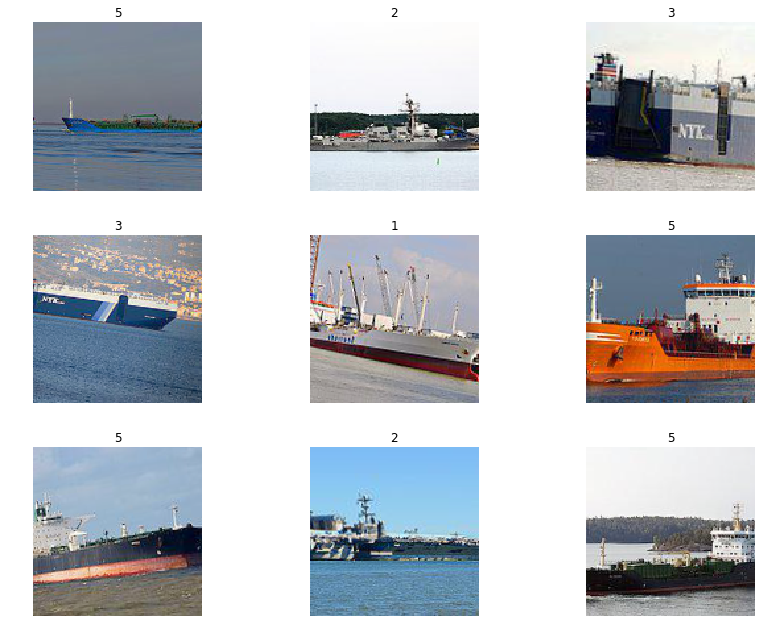

In [7]:
data.show_batch(rows=3, figsize=(12, 9))

In [8]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, f_score])

/home/sandip/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [9]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
1,1,2,3,2
Path: /home/sandip/Desktop/AV_Hackathon/DL_comp;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
4,1,1,3,4
Path: /home/sandip/Desktop/AV_Hackathon/DL_comp;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02


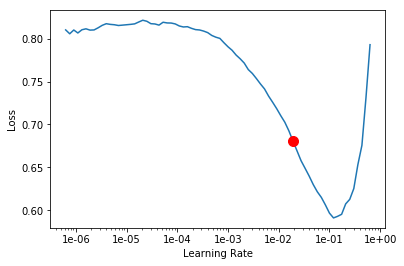

In [11]:
learn.recorder.plot(suggestion=True)

In [12]:
lr = 1.91E-02
learn.fit_one_cycle(16, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.367658,0.167241,0.912960,0.878571,00:15
1,0.181458,0.225869,0.906080,0.837333,00:15
2,0.158482,0.261839,0.875520,0.797681,00:15
3,0.153871,0.226335,0.911040,0.841505,00:15
4,0.158375,0.169531,0.912800,0.866233,00:15
5,0.143285,0.178896,0.928800,0.882762,00:15
6,0.137300,0.202612,0.910080,0.842381,00:15
7,0.126255,0.172661,0.926720,0.874438,00:15
8,0.114718,0.181963,0.926560,0.860424,00:15
9,0.105005,0.111560,0.940960,0.918919,00:15


In [13]:
learn.save('av_dl_fastai_densenet121_stage1')

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


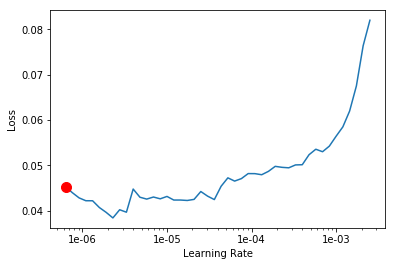

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(20, slice(1e-5, lr/20))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.044399,0.080895,0.965120,0.944629,00:18
1,0.047573,0.082053,0.966880,0.944781,00:18
2,0.047677,0.085152,0.965760,0.944114,00:18
3,0.045621,0.082424,0.966240,0.943771,00:19
4,0.044868,0.093196,0.961760,0.936590,00:19
5,0.046850,0.088402,0.960960,0.932381,00:19
6,0.040711,0.090528,0.964480,0.938933,00:18
7,0.040716,0.085045,0.968160,0.945105,00:19
8,0.038306,0.095639,0.964320,0.937981,00:18
9,0.033065,0.095389,0.965280,0.935733,00:19


In [17]:
learn.save('av_dl_fastai_densenet121_stage2')

# Switch Resolution

In [18]:
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data

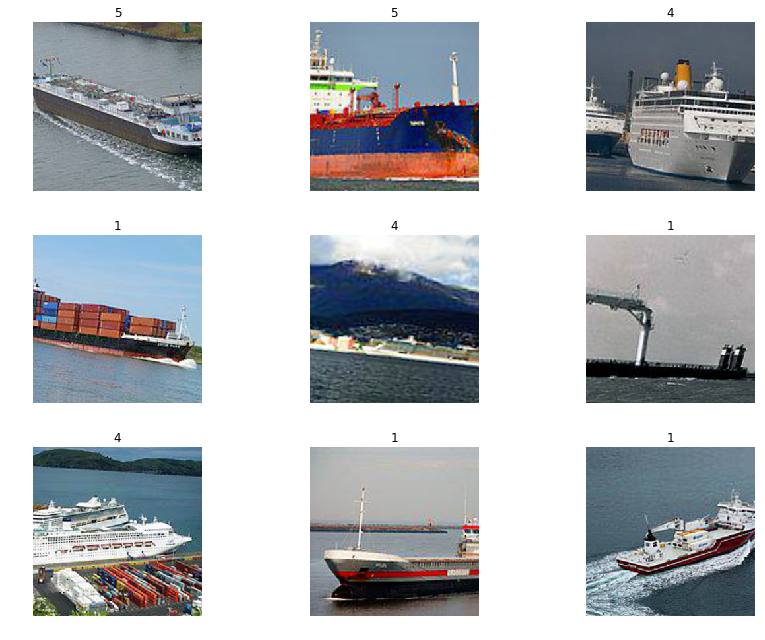

In [19]:
data.show_batch(rows=3, figsize=(12, 9))

In [20]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


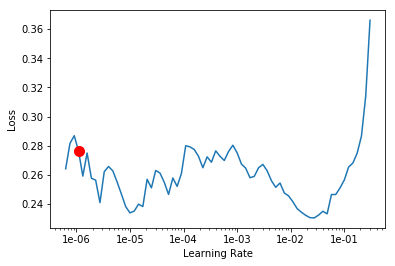

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [22]:
lr=1e-2/2
learn.fit_one_cycle(30, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.214420,0.181104,0.938560,0.876533,00:57
1,0.166223,0.137819,0.941600,0.900362,00:56
2,0.135726,0.115599,0.940960,0.913471,00:56
3,0.122757,0.099418,0.949120,0.921847,00:56
4,0.114018,0.096624,0.950400,0.927772,00:56
5,0.127307,0.089552,0.956480,0.933067,00:56
6,0.094759,0.085527,0.956960,0.937257,00:56
7,0.103930,0.093623,0.956480,0.929181,00:56
8,0.083099,0.086866,0.962400,0.934000,00:56
9,0.093481,0.084668,0.957440,0.935543,00:57


In [23]:
learn.save('av_dl_fastai_densenet121_stage3')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(30, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.050782,0.074476,0.970560,0.948838,01:11
1,0.054407,0.077455,0.969760,0.946000,01:10
2,0.045506,0.077308,0.968480,0.946343,01:10
3,0.053507,0.085319,0.968640,0.942571,01:10
4,0.058469,0.079684,0.968800,0.943505,01:10
5,0.055131,0.083794,0.965280,0.938133,01:10
6,0.065528,0.084960,0.966720,0.944133,01:10
7,0.059157,0.086804,0.963680,0.938000,01:10
8,0.060058,0.080336,0.964480,0.938133,01:11
9,0.054391,0.078486,0.966560,0.941733,01:11


In [25]:
learn.save('av_dl_fastai_densenet121_stage4')

In [26]:
learn.export()

# Make Predictions

In [27]:
path_test = '/home/sandip/Desktop/AV_Hackathon/DL_comp/test-jpg'

In [28]:
dataframes = []

for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    learn = load_learner(DIR, test=test)
    preds, y= learn.get_preds(ds_type=DatasetType.Test)
    y = torch.argmax(preds, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)


In [30]:
torch.save(preds, DIR + 'densenet121_256X256_preds_notta.pt')

In [31]:
sub_df = pd.DataFrame(df)
sub_df.head()

,image,category
0,2901960,3
1,2843667,1
2,1874363,4
3,2807078,2
4,2060547,2


In [32]:
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_Densenet121_256X256_notta_06042019v1.csv', index=False)

In [57]:
 densenet121_tensor=preds

# Let's do a round of TTA

In [58]:
dataframes = []

for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    learn = load_learner(DIR, test=test)
    preds, y= learn.TTA(ds_type=DatasetType.Test)
    y = torch.argmax(preds, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)

In [67]:
torch.save(preds, DIR + 'densenet121_256X256_preds_tta.pt')

In [59]:
sub_df = pd.DataFrame(df)
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_Densenet121_256X256_tta_06042019v1.csv', index=False)

# Mixing predictions from previous models

Let's load previously saved tensors

In [61]:
resnet152_notta = torch.load(DIR + 'resent152_256X256_preds_notta.pt')
resnet152_tta = torch.load(DIR + 'resent152_256X256_preds_tta.pt')

In [64]:
resnet_152_notta_pred = torch.Tensor.numpy(resnet152_notta)
resnet_152_tta_pred = torch.Tensor.numpy(resnet152_tta)
pred_dd = torch.Tensor.numpy(preds)
pred_dd_notta =torch.Tensor.numpy(densenet121_tensor)
avg_pred = np.mean([pred_dd_notta,pred_dd,resnet_152_notta_pred,resnet_152_tta_pred], axis=0)
avg_pred_tensor = torch.from_numpy(avg_pred)
dataframes = []
for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    #learn = load_learner(DIR, test=test)
    #preds, y= learn.get_preds(ds_type=DatasetType.Test)
    y = torch.argmax(avg_pred_tensor, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)

In [65]:
y

tensor([3, 1, 4,  ..., 4, 1, 5])

In [66]:
sub_df = pd.DataFrame(df)
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_Densenet121_Resent152_256X256_(tta_notta_avgd_06042019v1.csv', index=False)

In [36]:
avg_pred_list = [preds,resnet152_notta]

In [37]:
avg_pred = torch.mean(torch.stack(avg_pred_list)) 

In [38]:
avg_pred

tensor(0.1980)

In [41]:
dd = torch.Tensor.numpy(resnet152_notta)

pred_dd = torch.Tensor.numpy(preds)

In [44]:
avg_pred = np.mean([pred_dd,dd], axis=0)

In [45]:
avg_pred

array([[3.146558e-05, 6.547450e-06, 9.993690e-01, 2.663519e-04, 1.503615e-05],
       [9.988382e-01, 1.860079e-05, 1.783734e-06, 3.051274e-06, 5.269679e-04],
       [2.790618e-05, 6.595511e-06, 5.384782e-06, 9.997184e-01, 6.883698e-05],
       [2.124046e-05, 9.995286e-01, 1.666872e-05, 4.462014e-05, 5.245352e-06],
       ...,
       [5.126768e-02, 2.307391e-05, 2.248845e-04, 9.828338e-01, 1.867365e-04],
       [4.877865e-05, 1.179298e-05, 1.021266e-04, 9.995243e-01, 5.636150e-05],
       [9.962906e-01, 8.139821e-05, 1.415021e-05, 2.109033e-05, 1.471180e-04],
       [1.473574e-02, 2.103403e-05, 1.866788e-05, 5.236756e-07, 9.768870e-01]], dtype=float32)

In [46]:
avg_pred_tensor = torch.from_numpy(avg_pred)

In [47]:
avg_pred_tensor

tensor([[3.1466e-05, 6.5474e-06, 9.9937e-01, 2.6635e-04, 1.5036e-05],
        [9.9884e-01, 1.8601e-05, 1.7837e-06, 3.0513e-06, 5.2697e-04],
        [2.7906e-05, 6.5955e-06, 5.3848e-06, 9.9972e-01, 6.8837e-05],
        ...,
        [4.8779e-05, 1.1793e-05, 1.0213e-04, 9.9952e-01, 5.6361e-05],
        [9.9629e-01, 8.1398e-05, 1.4150e-05, 2.1090e-05, 1.4712e-04],
        [1.4736e-02, 2.1034e-05, 1.8668e-05, 5.2368e-07, 9.7689e-01]])

In [50]:
y = torch.argmax(avg_pred_tensor, dim=1)+1

In [52]:
dataframes = []
for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    #learn = load_learner(DIR, test=test)
    #preds, y= learn.get_preds(ds_type=DatasetType.Test)
    y = torch.argmax(avg_pred_tensor, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)

In [53]:
sub_df = pd.DataFrame(df)
sub_df.head()

,image,category
0,2901960,3
1,2843667,1
2,1874363,4
3,2807078,2
4,2060547,2


In [54]:
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_Densenet121_Resnet152_avg_256X256_notta_06042019v1.csv', index=False)